## Dynamic nanoscale architecture of synaptic vesicle fusion in mouse hippocampal neurons
### Mesoscopic simulation of synaptic vesicle docking -- part 1: kinetics

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from utilities import stats
import glob
from tqdm.notebook import tqdm

In [2]:
n_syt1_list = [0, 10, 20, 30]

In [3]:
combined_data_file_path = "./trajectory/combined_data.pkl"

combined_df = None

if not glob.glob(combined_data_file_path):
    print("Processed data file not found! Please run the 'data_preprocessor' notebook first!")
else:
    combined_df = pd.read_pickle(combined_data_file_path)

Example code of how you can access the data saved into the accumulated DataFrame:

<Axes: xlabel='Time [us]', ylabel='Vesicle-target gap [nm]'>

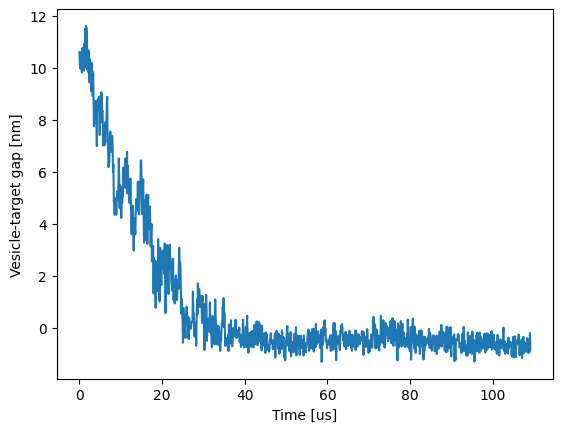

In [4]:
subset = combined_df.query(f"n_syt1 == {0} and replica == {1}")

subset.plot('time', 'vesicle_target_gap', legend=False, xlabel='Time [us]', ylabel='Vesicle-target gap [nm]')

In the following, we calculate the "SNARE-formation score" based on the pairwise distance between SNARE complex-representing particles in the simulated system:

In [5]:
r_ij_sum_lists = []

time_lists = []
vesicle_target_gap_lists = []

for n_syt1 in tqdm(n_syt1_list):
 
    r_ij_sum_list = []
    time_list = []
    vesicle_target_gap_list = []

    subset = combined_df.query(f"n_syt1 == {n_syt1}")
    
    n_replicas = np.amax(subset["replica"])
    
    for replica in range(1, n_replicas + 1):

        subset = combined_df.query(f"n_syt1 == {n_syt1} and replica == {replica}")
        
        time_list.append(subset['time'].to_numpy().copy())
        vesicle_target_gap_list.append(subset['vesicle_target_gap'].to_numpy().copy())
        
        pos_list = subset['all_pos'].to_numpy()
        type_list = subset['particle_types'].to_numpy()[0].astype(int)

        sel_v_SNARE = (type_list >= 6) * (type_list <= 9)
        sel_t_SNARE = (type_list >= 10) * (type_list <= 12)
        
        r_ij_sum = []
        
        for pos in pos_list:
            v_SNARE_pos = pos[sel_v_SNARE]
            t_SNARE_pos = pos[sel_t_SNARE]
        
            _r_ij_sum = 0.0
            
            for _t_pos in t_SNARE_pos:
                dx = _t_pos[:] - v_SNARE_pos[:, :]
        
                _r_ij_sum += np.sum(np.sqrt(np.sum(dx ** 2, axis=1)))
        
            r_ij_sum.append(_r_ij_sum)
    
        r_ij_sum_list.append(np.array(r_ij_sum))
        
    r_ij_sum_lists.append(stats.crop_arrays_to_min_size(r_ij_sum_list))
    time_lists.append(stats.crop_arrays_to_min_size(time_list))
    vesicle_target_gap_lists.append(stats.crop_arrays_to_min_size(vesicle_target_gap_list))


  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
def smooth_out(data):
    return stats.conv_smooth(x=data, window='flat', window_len=20)

def prepare_graphs (time_list, data_list):
    
    x = np.mean(time_list, axis=0)
    
    y = smooth_out(np.mean(data_list, axis=0))
    y_min = smooth_out(np.amin(data_list, axis=0))
    y_max = smooth_out(np.amax(data_list, axis=0))

    return x, y, y_min, y_max

(-3.0, 108.0)

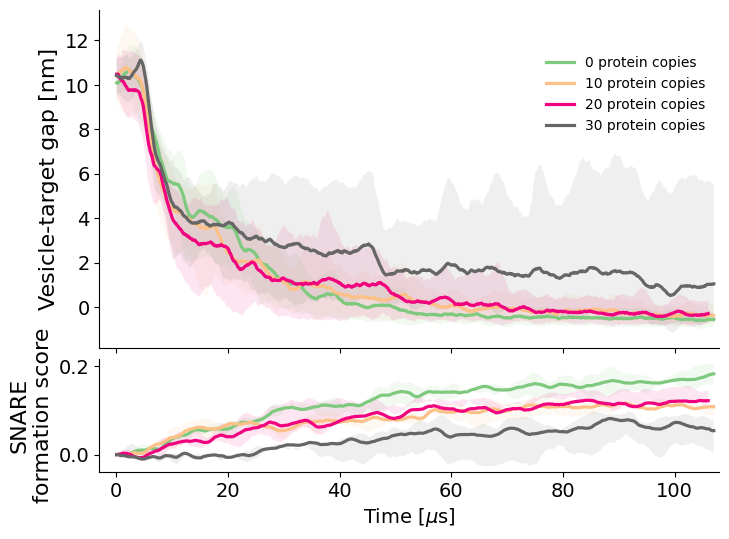

In [7]:
color_list = plt.get_cmap('Accent')(np.linspace(0, 1, len(time_lists)))

fig, ax = plt.subplots(nrows=2, figsize=(8, 6), sharex=True, height_ratios=[0.75, 0.25])

for _ax in ax:
    _ax.tick_params(axis='both', which='major', labelsize=14)

fig.subplots_adjust(hspace=0.05)

y_fun = lambda y: (y[0] - y) / y[0]

for time_list, vesicle_target_gap_list, r_ij_sum_list, color, n_syt1 in zip(time_lists,
                                                                            vesicle_target_gap_lists,
                                                                            r_ij_sum_lists,
                                                                            color_list, n_syt1_list):
    
    label = f"{n_syt1} protein copies"

    x, y, y_min, y_max = prepare_graphs(time_list, vesicle_target_gap_list)

    ax[0].plot(x, y, color=color, lw=2.3, solid_joinstyle='round', label=label)
    ax[0].fill_between(x, y_min, y_max, color=color, alpha=0.1, edgecolor='none')
    
    x, y, y_min, y_max = prepare_graphs(time_list, r_ij_sum_list)

    ax[1].plot(x, y_fun(y), color=color, lw=2.3, solid_joinstyle='round', label=label)
    ax[1].fill_between(x, y_fun(y_min), y_fun(y_max), color=color, alpha=0.1, edgecolor='none')

ax[1].set_xlabel(r"Time [$\mu$s]", fontsize=14)

ax[0].set_ylabel("Vesicle-target gap [nm]", fontsize=16)
ax[1].set_ylabel("SNARE\nformation score", fontsize=16)

ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)

ax[0].legend(bbox_to_anchor=[0.7, 0.6], frameon=False)
ax[0].set_xlim(-3.0, 108)

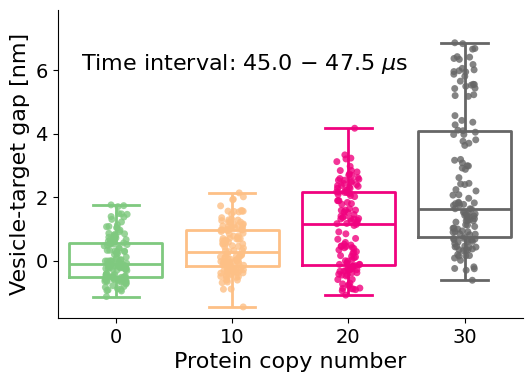

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

step1, step2 = 449, 474
n_bins = 10

dfs = []

for time_list, vesicle_target_gap_list, color, n_syt1 in zip(time_lists, vesicle_target_gap_lists, color_list, n_syt1_list):

    _time1 = np.mean(time_list, axis=0)[step1]
    _time2 = np.mean(time_list, axis=0)[step2]

    data = {}
    
    data['Copy number'] = n_syt1
    
    gap_sample = []
        
    for frame in range(step1, step2):
        for vesicle_target_gap in vesicle_target_gap_list:
            gap_sample.append(vesicle_target_gap[frame])

    data['Vesicle-target gap [nm]'] = gap_sample.copy()

    df = pd.DataFrame(data)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

sns.stripplot(x='Copy number', y='Vesicle-target gap [nm]', data=combined_df, palette=color_list.tolist(), hue='Copy number', legend=False,
              s=5, linewidth=0, alpha=0.8, size=4, jitter=True)
sns.boxplot(x='Copy number', y='Vesicle-target gap [nm]', data=combined_df, palette=color_list.tolist(), hue='Copy number', legend=False,
            linewidth=2, fill=False)

ax.set_ylim(-1.8, 7.9)

ax.set_ylabel("Vesicle-target gap [nm]", fontsize=16)
ax.set_xlabel("Protein copy number", fontsize=16)

ax.spines[['right', 'top']].set_visible(False)

ax.text(-0.3, 6, rf"Time interval: {_time1:2.1f} $-$ {_time2:2.1f} $\mu$s", fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)